In [ ]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install scikit-learn
%pip install gensim
%pip install numpy==1.26.4

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")

file_path = "arxiv.csv"  # File in locale poiché convertito localmente da JSON a csv

# Carica il file CSV in un DataFrame
df = pd.read_csv(file_path)

# Stampa il numero di righe e mostra le prime righe
print(f"Numero di righe nel dataset: {df.shape[0]}")
df.head()

Numero di righe nel dataset: 2626136


,id,submitter,authors,title,comments,journal-ref,doi,categories,abstract,update_date
0,704.0001,Pavel Nadolsky,"Balázs C., Berger E. L., Nadolsky P. M., Yuan ...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,hep-ph,A fully differential calculation in perturba...,2008-11-26
1,704.0002,Louis Theran,"Streinu Ileana, Theran Louis",Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,NaN,math.CO cs.CG,"We describe a new algorithm, the $(k,\ell)$-...",2008-12-13
2,704.0003,Hongjun Pan,Pan Hongjun,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,NaN,physics.gen-ph,The evolution of Earth-Moon system is descri...,2008-01-13
3,704.0004,David Callan,Callan David,A determinant of Stirling cycle numbers counts...,11 pages,NaN,NaN,math.CO,We show that a determinant of Stirling cycle...,2007-05-23
4,704.0005,Alberto Torchinsky,"Abu-Shammala Wael, Torchinsky Alberto",From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,NaN,"Illinois J. Math. 52 (2008) no.2, 681-689",NaN,math.CA math.FA,In this paper we show how to compute the $\L...,2013-10-15


In [2]:
df = df.sample(n=10000, random_state=42)

df1 = df.drop(columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'update_date'])

df1.head()

,categories,abstract
698896,stat.ME cs.IT math.IT,"In this paper, we study the quickest change ..."
2485786,hep-th gr-qc hep-ph,In this essay we introduce a theoretical fra...
1451689,astro-ph.EP,We investigate the origins of the photometri...
1194288,cs.CV cs.LG,Monocular Depth Estimation is usually treate...
1354541,cs.LG stat.ML,Graph Attention Networks(GATs) are useful de...


In [3]:
df1 = df1[df1['categories'].apply(lambda x: isinstance(x, str) and ',' not in x and ' ' not in x)]
print(f"Numero di righe nel dataset: {df1.shape[0]}")
df1.head()

Numero di righe nel dataset: 5239


,categories,abstract
1451689,astro-ph.EP,We investigate the origins of the photometri...
2148721,hep-ph,We study the production of vector portal med...
2097152,cs.CV,Cross-modality transfer aims to leverage lar...
158335,hep-ph,One of the major open issues in neutrino phy...
2414575,hep-ph,We compute the cross section for neutrino-ph...


In [4]:
# Rimuovere duplicati
df1 = df1.drop_duplicates()

# Verificare e gestire dati mancanti
df1 = df1.dropna().reset_index(drop=True)  # Rimuove righe con valori NaN

print(f"Numero di righe nel dataset dopo la pulizia: {df1.shape[0]}")

df1.head()

Numero di righe nel dataset dopo la pulizia: 5239


,categories,abstract
0,astro-ph.EP,We investigate the origins of the photometri...
1,hep-ph,We study the production of vector portal med...
2,cs.CV,Cross-modality transfer aims to leverage lar...
3,hep-ph,One of the major open issues in neutrino phy...
4,hep-ph,We compute the cross section for neutrino-ph...


In [5]:
def clean_text(text):
    # Rimuove link, caratteri speciali e converte in minuscolo
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)  # Rimuove menzioni e hashtag
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)  # Mantiene solo lettere e numeri
    text = text.lower()  # Converte in minuscolo
    text = text.strip()  # Rimuove spazi extra
    return text

# Applicare la pulizia
df1['abstract'] = df1['abstract'].apply(clean_text)

df1.head()

,categories,abstract
0,astro-ph.EP,we investigate the origins of the photometrica...
1,hep-ph,we study the production of vector portal media...
2,cs.CV,crossmodality transfer aims to leverage large ...
3,hep-ph,one of the major open issues in neutrino physi...
4,hep-ph,we compute the cross section for neutrinophoto...


categories
hep-ph              329
astro-ph            295
quant-ph            293
cs.CV               264
hep-th              250
                   ... 
physics.atm-clus      1
q-fin.TR              1
math.KT               1
math.SP               1
q-bio.CB              1
Name: count, Length: 144, dtype: int64


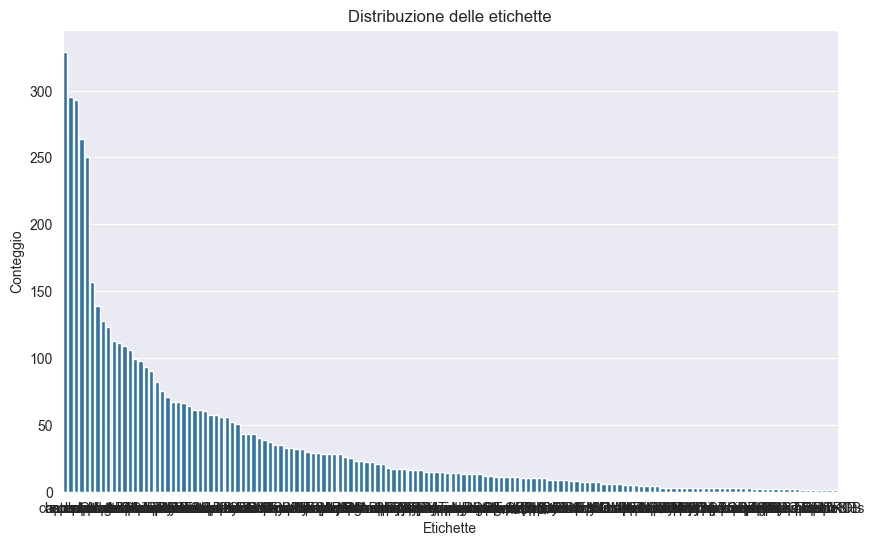

In [6]:
# Controlla la distribuzione delle etichette
label_counts = df1['categories'].value_counts()

# Stampa i conteggi
print(label_counts)

# Visualizza la distribuzione
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribuzione delle etichette")
plt.xlabel("Etichette")
plt.ylabel("Conteggio")
plt.show()

In [7]:
# Definisci le 5 categorie principali su cui concentrarti
top_4_categories = ['astro-ph', 'hep-ph', 'quant-ph', 'cs.CV']

# Filtra il dataset per mantenere solo le righe con le categorie principali
df1 = df1[df1['categories'].isin(top_4_categories)]

df1.reset_index(drop=True)

print(f"Numero di righe nel dataset dopo la pulizia: {df1.shape[0]}")

df1.head()

Numero di righe nel dataset dopo la pulizia: 1181


,categories,abstract
1,hep-ph,we study the production of vector portal media...
2,cs.CV,crossmodality transfer aims to leverage large ...
3,hep-ph,one of the major open issues in neutrino physi...
4,hep-ph,we compute the cross section for neutrinophoto...
6,quant-ph,entanglement is widely believed to lie at the ...


categories
hep-ph      329
astro-ph    295
quant-ph    293
cs.CV       264
Name: count, dtype: int64


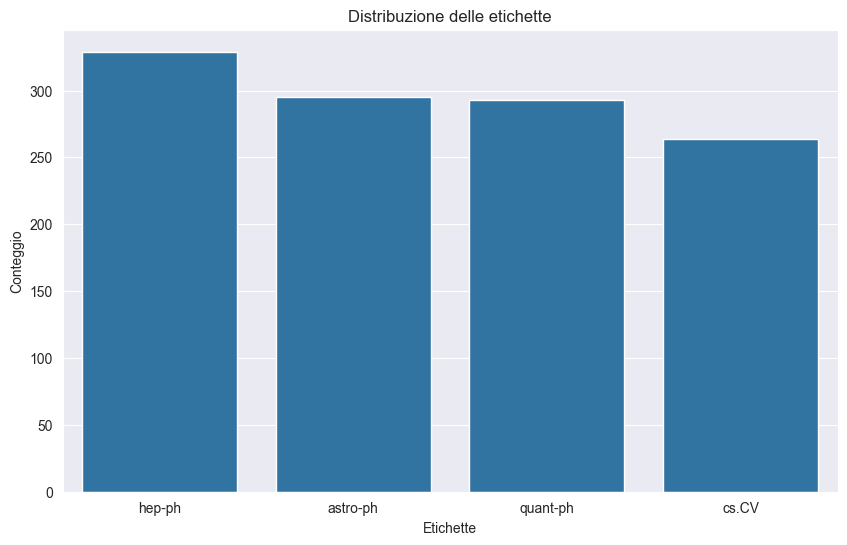

In [8]:
# Controlla la distribuzione delle etichette
label_counts = df1['categories'].value_counts()

# Stampa i conteggi
print(label_counts)

# Visualizza la distribuzione
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribuzione delle etichette")
plt.xlabel("Etichette")
plt.ylabel("Conteggio")
plt.show()

categories
astro-ph    264
cs.CV       264
hep-ph      264
quant-ph    264
Name: count, dtype: int64


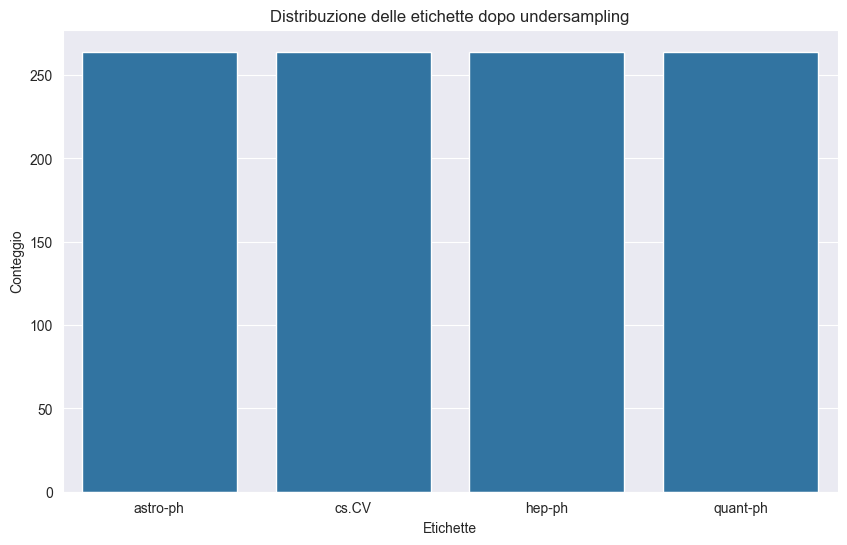

In [9]:
# Undersampling: trovare la dimensione della classe minoritaria
min_class_size = label_counts.min()

# Creare un nuovo dataset con undersampling
undersampled_data = df1.groupby('categories').sample(n=min_class_size, random_state=42)

# Verificare la nuova distribuzione delle etichette
undersampled_label_counts = undersampled_data['categories'].value_counts()

print(undersampled_label_counts)

# Visualizzare la nuova distribuzione delle etichette
plt.figure(figsize=(10, 6))
sns.barplot(x=undersampled_label_counts.index, y=undersampled_label_counts.values)
plt.title("Distribuzione delle etichette dopo undersampling")
plt.xlabel("Etichette")
plt.ylabel("Conteggio")
plt.show()

In [10]:
# Pulizia dei testi
abstract = undersampled_data['abstract']

# Contare le parole in ogni testo
word_counts = abstract.apply(lambda x: len(str(x).split()))

# Calcolare il massimo numero di parole e il testo corrispondente
max_word_count = word_counts.max()

# Assicurarsi che l'indice massimo sia un intero e ottenere il testo corrispondente
max_word_index = word_counts.idxmax()
max_word_text = abstract.loc[max_word_index]

# Calcolare la media delle parole
mean_word_count = word_counts.mean()

# Stampare i risultati
print(f"Massimo numero di parole: {max_word_count}")
print(f"Testo con più parole: {max_word_text}")
print(f"Media del numero di parole: {mean_word_count:.2f}")

Massimo numero di parole: 308
Testo con più parole: abridged we present r600 1037um spectra of 53 ulirgs at z032 taken
using the irs on board spitzer all of the spectra show fine structure emission
lines of ne o s si and ar as well as molecular hydrogen lines some ulirgs
also show emission lines of cl fe p and atomic hydrogen andor absorption
features from c2h2 hcn and oh we employ diagnostics based on the
finestructure lines as well as the ews and luminosities of pah features and
the strength of the 97um silicate absorption feature ssil to explore the
power source behind the infrared emission in ulirgs we show that the ir
emission from the majority of ulirgs is powered mostly by star formation with
only 20 of ulirgs hosting an agn with a comparable or greater ir luminosity
than the starburst the detection of the 1432um nev line in just under half
the sample however implies that an agn contributes significantly to the midir
flux in 42 of ulirgs the emission line ratios luminosities and

# Classificazione

In [11]:
from sklearn.model_selection import train_test_split

# Caricamento del dataset generale
X = undersampled_data['abstract']        # Colonna dei testi
y = undersampled_data['categories']      # Colonna delle label

# Step 1: Divisione del dataset generale in training e test set (70%-30%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Divisione del training set in training (85%) e validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full)

# Verifica delle dimensioni
print("Dimensioni del dataset:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")

Dimensioni del dataset:
Training set: 628
Validation set: 111
Test set: 317


#### Trasformazione in vettori di feature

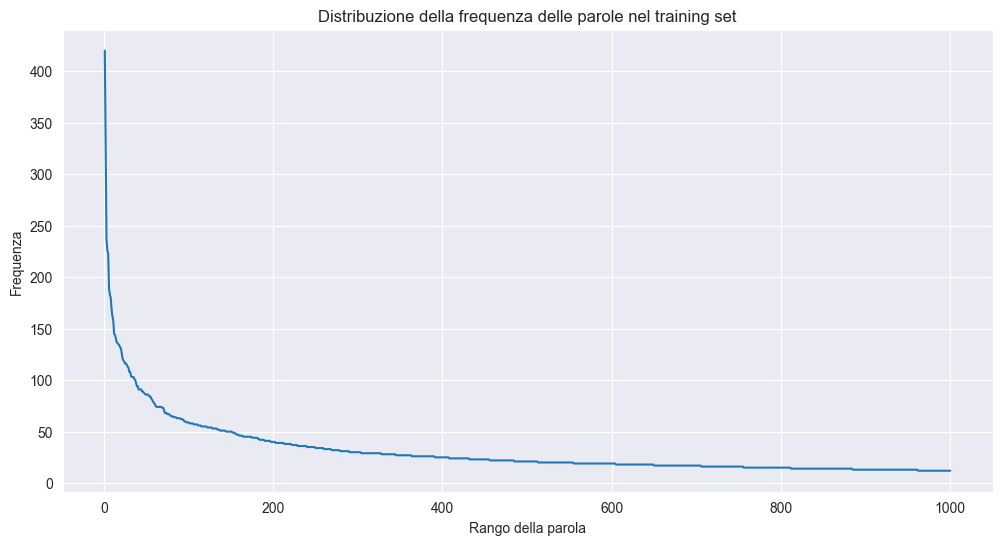

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Calcolo della frequenza delle parole
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(X_train)  # Usa il nuovo training set

# Ordinare le parole per frequenza
word_freq = dict(zip(vectorizer.get_feature_names_out(), X_counts.sum(axis=0).A1))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Plot della distribuzione delle parole più frequenti
top_words = 1000  # Analizza le prime 1000 parole
plt.figure(figsize=(12, 6))
plt.plot(range(1, top_words + 1), [freq for _, freq in sorted_word_freq[:top_words]])
plt.xlabel('Rango della parola')
plt.ylabel('Frequenza')
plt.title('Distribuzione della frequenza delle parole nel training set')
plt.show()

Il grafico è stato realizzato per una scelta ottimale del parametro <tt>`max_features`</tt> da scegliere per la trasformazione in vettori di feature.
Si nota la curva segue la distribuzione di Zipf, dove poche parole hanno una frequenza molto alta, mentre la maggior parte delle parole appare poche volte.

Intorno alle 150-200 parole si osserva un brusco calo della frequenza ed oltre le 500 parole, la frequenza diventa molto bassa.

Dunque, per la scelta di max_features si hanno due strade:
- valore pari a 500-1000 basandosi sulla curva;
- valore tra 3000-5000 per catturare anche le code lunghe.

I valori vanno testati empiricamente.

# TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit e trasformazione per il nuovo training, validation e test set
X_train_tfidf = vectorizer.fit_transform(X_train)   # Nuovo training set
X_val_tfidf = vectorizer.transform(X_val)          # Nuovo validation set
X_test_tfidf = vectorizer.transform(X_test)        # Nuovo test set

# Verifica delle dimensioni
print(f"Shape X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape X_val_tfidf: {X_val_tfidf.shape}")
print(f"Shape X_test_tfidf: {X_test_tfidf.shape}")

Shape X_train_tfidf: (628, 1000)
Shape X_val_tfidf: (111, 1000)
Shape X_test_tfidf: (317, 1000)


# Word2Vec

In [19]:
import gensim
import numpy as np

# Tokenizzazione dei testi
X_train_tokens = [doc.split() for doc in X_train]  # Divide ogni documento in parole
X_val_tokens = [doc.split() for doc in X_val]
X_test_tokens = [doc.split() for doc in X_test]

# Addestramento di Word2Vec sui dati di training
word2vec_model = gensim.models.Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Funzione per calcolare la media delle embedding per ciascun documento
def get_average_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Trasformazione dei set in embedding medie
X_train_tfidf = np.array([get_average_embedding(tokens, word2vec_model) for tokens in X_train_tokens])
X_val_tfidf = np.array([get_average_embedding(tokens, word2vec_model) for tokens in X_val_tokens])
X_test_tfidf = np.array([get_average_embedding(tokens, word2vec_model) for tokens in X_test_tokens])

# Verifica delle dimensioni
print(f"Shape X_train_w2v: {X_train_tfidf.shape}")
print(f"Shape X_val_w2v: {X_val_tfidf.shape}")
print(f"Shape X_test_w2v: {X_test_tfidf.shape}")

Shape X_train_w2v: (628, 100)
Shape X_val_w2v: (111, 100)
Shape X_test_w2v: (317, 100)


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Addestramento del modello Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)  # Usa il nuovo training set

# Valutazione sul validation set
y_pred_val_nb = nb_model.predict(X_val_tfidf)

# Report delle metriche
print("Naive Bayes Validation Accuracy:", accuracy_score(y_val, y_pred_val_nb))
print("Classification Report sul Validation Set:\n", classification_report(y_val, y_pred_val_nb))

#### Test set - Naive Bayes

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Valutazione sul test set
y_pred_test = nb_model.predict(X_test_tfidf)

# Calcolo della accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Naive Bayes Test Accuracy:", test_accuracy)

# Report dettagliato di classificazione
print("Test Set Classification Report:\n", classification_report(y_test, y_pred_test))

# Calcolo della matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Visualizzazione con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### Curva ROC

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarizzare le etichette (necessario per calcolare la curva ROC)
classes = nb_model.classes_
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_proba = nb_model.predict_proba(X_test_tfidf)

# Calcolo della curva ROC per ciascuna classe
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc_score:.2f})")

# Linea di riferimento
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Etichette e legenda
plt.title("ROC Curve - Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Addestramento del modello Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)  # Usa il nuovo training set

# Valutazione sul validation set
y_pred_val_lr = lr_model.predict(X_val_tfidf)

# Report delle metriche
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, y_pred_val_lr))
print("Classification Report sul Validation Set:\n", classification_report(y_val, y_pred_val_lr))

Logistic Regression Validation Accuracy: 0.3063063063063063
Classification Report sul Validation Set:
               precision    recall  f1-score   support

    astro-ph       0.40      0.07      0.12        28
       cs.CV       0.44      0.25      0.32        28
      hep-ph       0.00      0.00      0.00        27
    quant-ph       0.29      0.89      0.44        28

    accuracy                           0.31       111
   macro avg       0.28      0.30      0.22       111
weighted avg       0.29      0.31      0.22       111



#### Test Set - Logistic Regression

Logistic Regression Test Accuracy: 0.27129337539432175
Test Set Classification Report:
               precision    recall  f1-score   support

    astro-ph       0.62      0.13      0.21        79
       cs.CV       0.44      0.18      0.25        79
      hep-ph       0.06      0.03      0.03        80
    quant-ph       0.26      0.76      0.38        79

    accuracy                           0.27       317
   macro avg       0.34      0.27      0.22       317
weighted avg       0.34      0.27      0.22       317



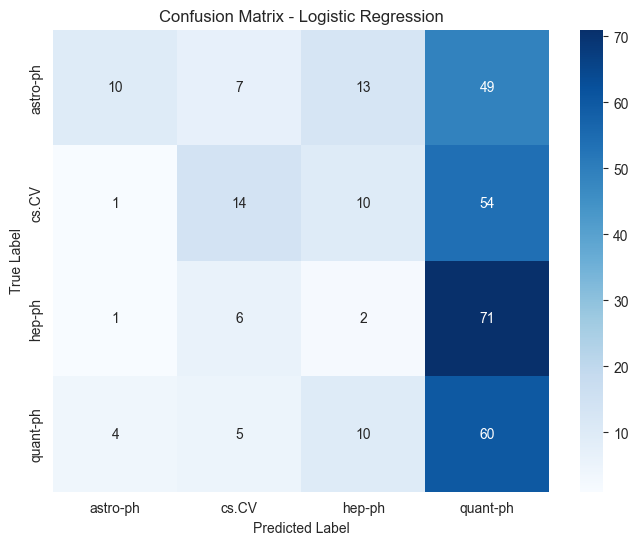

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Valutazione sul test set
y_pred_test_lr = lr_model.predict(X_test_tfidf)

# Calcolo della accuracy
test_accuracy_lr = accuracy_score(y_test, y_pred_test_lr)
print("Logistic Regression Test Accuracy:", test_accuracy_lr)

# Report dettagliato di classificazione
print("Test Set Classification Report:\n", classification_report(y_test, y_pred_test_lr))

# Calcolo della matrice di confusione
conf_matrix_lr = confusion_matrix(y_test, y_pred_test_lr)

# Visualizzazione con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Curva ROC

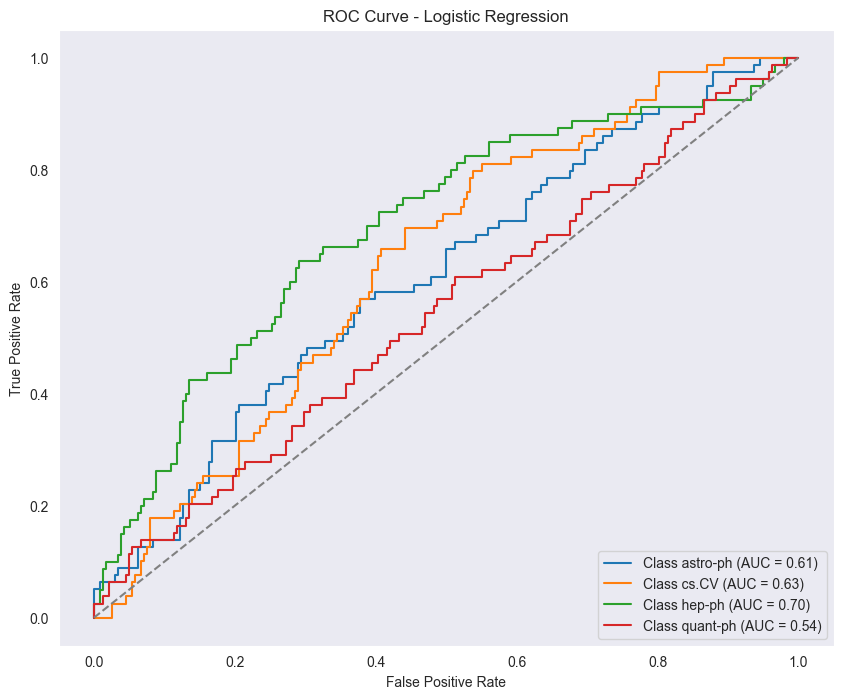

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarizzare le etichette (necessario per calcolare la curva ROC)
classes = lr_model.classes_  # Modifica per Logistic Regression
y_test_binarized = label_binarize(y_test, classes=classes)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)  # Predizione delle probabilità

# Calcolo della curva ROC per ciascuna classe
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba_lr[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba_lr[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc_score:.2f})")

# Linea di riferimento
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Etichette e legenda
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Support Vector Machine (SVM)

Per verificare la separabilità dei dati del dataset originale, poiché le feature sono categoriche, si deve utilizzare un Encoder per renderle numeriche.

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assicurarsi che X sia un DataFrame
if isinstance(X, pd.Series):
    X = X.to_frame()  # Convertire la Series in DataFrame

# Encoding di ogni colonna categorica
label_encoders = {}
for col in X.columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assicurati che X sia un DataFrame con tutte le feature numeriche
linear_check_df = X.copy()  # Prendi tutte le colonne di X
linear_check_df['categories'] = y  # Aggiungi la colonna target

# Pair plot delle feature colorate per classe
sns.pairplot(linear_check_df, hue="categories", diag_kind="kde", markers=["o", "s"])

# Mostra il grafico
plt.suptitle("Pair Plot - Linear Separability Check", y=1.02)
plt.show()

Possiamo cercare di rappresentare i dati del dataset trasformato con TF-IDF in 2D tramite la TSNE, ma poiché TF-IDF lavora ad alta dimensionalità (circa 1000), la raffigurazione in 2D ottenuta con la TSNE potrebbe non essere accurata.

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# t-SNE: Riduzione dimensionale a 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_train_tsne = tsne.fit_transform(X_train_tfidf.toarray())  # Converti in array denso per t-SNE

# Creare un DataFrame per la visualizzazione
tsne_df = pd.DataFrame(X_train_tsne, columns=["TSNE1", "TSNE2"])
tsne_df['categories'] = y_train.reset_index(drop=True)  # Aggiungi la colonna target

# Visualizzazione dei risultati t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="categories", palette="Set1", alpha=0.7)
plt.title("Proiezione t-SNE delle Feature TF-IDF - Verifica Separabilità Lineare")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Categories")
plt.show()

Anche se i punti non sono separabili in 2D, possono esserlo in uno spazio di 1000 dimensioni dove le feature TF-IDF hanno un'importanza diversa.

Se si usa Word2Vec:

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# t-SNE: Riduzione dimensionale a 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_train_tsne = tsne.fit_transform(X_train_tfidf)  # Non serve .toarray()

# Creare un DataFrame per la visualizzazione
tsne_df = pd.DataFrame(X_train_tsne, columns=["TSNE1", "TSNE2"])
tsne_df['categories'] = y_train.reset_index(drop=True)  # Aggiungi la colonna target

# Visualizzazione dei risultati t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="categories", palette="Set1", alpha=0.7)
plt.title("Proiezione t-SNE delle Feature Word2Vec - Verifica Separabilità Lineare")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Categories")
plt.show()

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Addestramento del modello SVM
svm_model = LinearSVC(max_iter=1000, random_state=42)
svm_model.fit(X_train_tfidf, y_train)  # Usa il nuovo training set

# Valutazione sul validation set
y_pred_val_svm = svm_model.predict(X_val_tfidf)

# Report delle metriche
print("SVM Validation Accuracy:", accuracy_score(y_val, y_pred_val_svm))
print("Classification Report sul Validation Set:\n", classification_report(y_val, y_pred_val_svm))

#### Test Set - Linear SVM

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Valutazione sul test set
y_pred_test_svm = svm_model.predict(X_test_tfidf)

# Calcolo della accuracy
test_accuracy_svm = accuracy_score(y_test, y_pred_test_svm)
print("Linear SVM Test Accuracy:", test_accuracy_svm)

# Report dettagliato di classificazione
print("Test Set Classification Report:\n", classification_report(y_test, y_pred_test_svm))

# Calcolo della matrice di confusione
conf_matrix_svm = confusion_matrix(y_test, y_pred_test_svm)

# Visualizzazione con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("Confusion Matrix - Linear SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Curva ROC

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Addestrare SVC con kernel lineare e abilitare le probabilità
svm_model_proba = SVC(kernel="linear", probability=True, random_state=42)
svm_model_proba.fit(X_train_tfidf, y_train)

# Binarizzare le etichette (necessario per la curva ROC)
classes = svm_model_proba.classes_  # Classi del modello
y_test_binarized = label_binarize(y_test, classes=classes)

# Predizione delle probabilità
y_pred_proba_svm = svm_model_proba.predict_proba(X_test_tfidf)

# Calcolo della curva ROC per ciascuna classe
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba_svm[:, i])
    auc_score = roc_auc_score(y_test_binarized[:, i], y_pred_proba_svm[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {auc_score:.2f})")

# Linea di riferimento
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Etichette e legenda
plt.title("ROC Curve - Linear SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()